In [75]:
import sys
sys.path.insert(0, '../Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from pysr import PySRRegressor
import sympy 
import pandas as pd

In [76]:
print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# tf.debugging.set_log_device_placement(True)




[]
Num GPUs Available:  0


In [77]:
# Configurar para usar solo la memoria necesaria
# physical_devices = tf.config.list_physical_devices('GPU')
# if physical_devices:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)
#     print('done')

In [78]:

# Carga los archivos .xlsx
file1 = '../DataExperiments/WT_in_LB_data_s1.XLSX'
file2 = '../DataExperiments/different_conditions_data_s2.XLSX'

# Lee las hojas de los archivos
df1 = pd.read_excel(file1, engine='openpyxl')  # Especifica la hoja si es necesario: sheet_name='nombre_hoja'
df2 = pd.read_excel(file2, engine='openpyxl')

# Cambiar la fila 0 a la nueva cabecera
df2.columns = df2.iloc[0]  # Establecer la primera fila como nueva cabecera
df2 = df2[1:]  # Eliminar la primera fila

# Reiniciar los índices (opcional, si quieres que empiece desde 0)
df2 = df2.reset_index(drop=True)

# Muestra los DataFrames
print("Archivo 1:")
display(df1)

print("Archivo 2:")
display(df2)


Archivo 1:


,Cycle Nr.,Time [s],Temp. [°C],G4,G5,G6,G7,G8,G9,G10,G11,G12,H1,H2,H3,H4,H5,H6
0,1,0.0,30.8,0.0922,0.0928,0.0928,0.0931,0.0928,0.0927,0.0916,0.0921,0.0911,0.0936,0.0925,0.0918,0.0929,0.0931,0.0931
1,2,678.6,30.7,0.0951,0.0957,0.0959,0.0959,0.0957,0.0953,0.0947,0.0951,0.0941,0.0970,0.0958,0.0951,0.0963,0.0963,0.0962
2,3,1357.1,30.4,0.0951,0.0958,0.0957,0.0960,0.0958,0.0954,0.0947,0.0951,0.0943,0.0971,0.0959,0.0952,0.0965,0.0964,0.0963
3,4,2035.7,30.2,0.0955,0.0962,0.0961,0.0965,0.0964,0.0958,0.0950,0.0957,0.0947,0.0975,0.0964,0.0957,0.0969,0.0969,0.0969
4,5,2714.2,30.0,0.0960,0.0969,0.0965,0.0968,0.0968,0.0964,0.0956,0.0963,0.0953,0.0981,0.0969,0.0961,0.0974,0.0973,0.0973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,495,335199.8,30.8,0.8186,0.8214,0.8188,0.8198,0.8221,0.8201,0.8296,0.8418,0.8292,0.4360,0.7711,0.8043,0.8181,0.8181,0.8153
495,496,335878.3,30.9,0.8184,0.8222,0.8185,0.8178,0.8201,0.8182,0.8277,0.8379,0.8274,0.4379,0.7729,0.8038,0.8198,0.8180,0.8154
496,497,336556.8,30.8,0.8183,0.8222,0.8169,0.8204,0.8214,0.8186,0.8287,0.8409,0.8289,0.4304,0.7719,0.8040,0.8187,0.8172,0.8154
497,498,337235.3,30.8,0.8172,0.8211,0.8194,0.8206,0.8227,0.8201,0.8303,0.8417,0.8280,0.4321,0.7717,0.8043,0.8194,0.8173,0.8143


Archivo 2:


,Cycle Nr.,Time [s],Temp. [°C],A1,A2,A3,A4,A5,A6,A7,...,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11
0,1,0,30,0.0929,0.0971,0.0948,0.0961,0.0939,0.0934,0.0938,...,0.0913,0.0914,0.0924,0.0916,0.0925,0.0921,0.092,0.093,0.0927,0.093
1,2,678.6,30.5,0.0925,0.0962,0.0946,0.0953,0.0935,0.0931,0.0933,...,0.0913,0.0916,0.0926,0.092,0.0914,0.0921,0.0921,0.0931,0.0932,0.0925
2,3,1357.2,30.1,0.0926,0.0962,0.095,0.0954,0.0936,0.0932,0.0932,...,0.0916,0.0917,0.0927,0.0918,0.0917,0.0922,0.0923,0.0932,0.0932,0.0927
3,4,2035.8,30,0.0928,0.0981,0.0949,0.0956,0.0937,0.0934,0.0934,...,0.092,0.0921,0.0931,0.0922,0.0922,0.0928,0.0926,0.0936,0.0937,0.093
4,5,2714.4,30.3,0.0933,0.0985,0.0953,0.096,0.0942,0.0939,0.0938,...,0.0925,0.0927,0.0937,0.0928,0.093,0.0933,0.0933,0.0943,0.0944,0.0938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,338,228685.2,29.9,0.5954,0.6453,0.6513,0.6593,0.6599,0.6576,0.5901,...,0.0926,0.0926,0.0935,0.0924,0.0949,1.0018,0.9769,0.9848,0.9871,0.9972
338,339,229363.7,29.8,0.5937,0.6448,0.6495,0.6568,0.6572,0.6564,0.5898,...,0.0926,0.0927,0.0934,0.0926,0.0953,1.0017,0.98,0.9857,0.9868,0.9976
339,340,230042.3,29.9,0.5923,0.6429,0.6487,0.6575,0.6589,0.6572,0.5889,...,0.0925,0.0925,0.0933,0.0923,0.0947,1.0009,0.9758,0.9833,0.9846,0.9963
340,341,230720.9,30.3,0.5912,0.6419,0.6484,0.6568,0.657,0.6548,0.5888,...,0.0923,0.0924,0.0932,0.0921,0.0942,1.0004,0.9763,0.9843,0.9845,0.9981


In [79]:
P0_exp=df2.iloc[:, -5:]
P1_exp=df2.iloc[:, 3:9]
P2_exp=df2.iloc[:, 9:14]
P3_exp=df2.iloc[:, [15,19,20]]


P0_exp, P1_exp, P2_exp, P3_exp


(0        H7      H8      H9     H10     H11
 0    0.0921   0.092   0.093  0.0927   0.093
 1    0.0921  0.0921  0.0931  0.0932  0.0925
 2    0.0922  0.0923  0.0932  0.0932  0.0927
 3    0.0928  0.0926  0.0936  0.0937   0.093
 4    0.0933  0.0933  0.0943  0.0944  0.0938
 ..      ...     ...     ...     ...     ...
 337  1.0018  0.9769  0.9848  0.9871  0.9972
 338  1.0017    0.98  0.9857  0.9868  0.9976
 339  1.0009  0.9758  0.9833  0.9846  0.9963
 340  1.0004  0.9763  0.9843  0.9845  0.9981
 341  1.0014  0.9772  0.9853  0.9843  0.9956
 
 [342 rows x 5 columns],
 0        A1      A2      A3      A4      A5      A6
 0    0.0929  0.0971  0.0948  0.0961  0.0939  0.0934
 1    0.0925  0.0962  0.0946  0.0953  0.0935  0.0931
 2    0.0926  0.0962   0.095  0.0954  0.0936  0.0932
 3    0.0928  0.0981  0.0949  0.0956  0.0937  0.0934
 4    0.0933  0.0985  0.0953   0.096  0.0942  0.0939
 ..      ...     ...     ...     ...     ...     ...
 337  0.5954  0.6453  0.6513  0.6593  0.6599  0.6576
 338  0.5

In [80]:
P2_exp.shape

(342, 5)

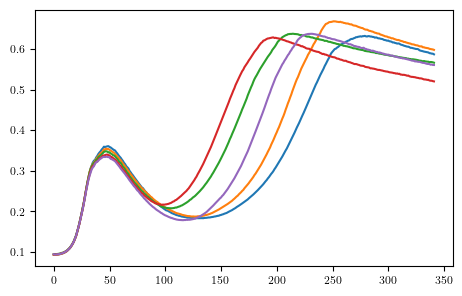

In [81]:
plt.plot(P2_exp)

In [82]:
P1_exp.shape

(342, 6)

In [83]:
c=-1
P_exp=np.hstack((P0_exp,P1_exp,P2_exp,P3_exp))
T_exp=np.array(df2['Time [s]'])

T_max=max(T_exp)
T_exp=T_exp/max(T_exp)
N_exp=P_exp.shape[1]
n=np.array([P0_exp.shape[1],P1_exp.shape[1],P2_exp.shape[1],P3_exp.shape[1]])
A_orig=np.array([0, 1.25, 2.50, 3.75])
A=(A_orig-min(A_orig))/max(A_orig)
N_exp,T_max, T_exp.shape, P_exp.shape, 342*23

(19, 231399.5, (342,), (342, 19), 7866)

In [84]:
A

array([0.        , 0.33333333, 0.66666667, 1.        ])

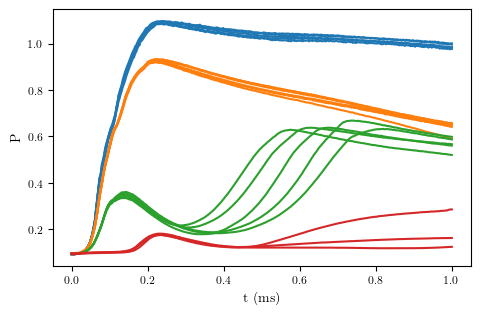

In [85]:
colors = plt.cm.tab10.colors

for k, j in enumerate(n):
    # Seleccionar el color correspondiente de la paleta
    color = colors[k % len(colors)]  # Asegurarse de que no se salga del rango de colores disponibles
    for i in range(j):
        # Aquí puedes pasar el color seleccionado en cada iteración
        plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)

plt.xlabel('t (ms)')
plt.ylabel('P')
plt.show()

In [86]:
N_f = 1500 # Number of residual point
N_d = 1500 #Number of data

P_star = P_exp.T.flatten().reshape([-1,1])
Xa_star=[]
P0_star=np.empty((0, 1))
A0_star=np.empty((0, 1))
X_star = np.empty((0, 3))
for i in range(len(A)):
    P0=P_exp[0:1, np.sum(n[:i]):np.sum(n[:i+1])]
    P0_star=np.concatenate((P0_star,P0.T))
    A0_star=np.concatenate((A0_star, np.array([A[i]]*n[i]).reshape([-1,1])))
    T_meshgrid, P0_meshgrid, A_meshgrid = np.meshgrid(T_exp, P0, A[i])
    x=np.hstack((T_meshgrid.flatten()[:,None], P0_meshgrid.flatten()[:,None], A_meshgrid.flatten()[:,None]))
    Xa_star += [x]
    X_star=np.vstack((X_star,x))


u_star=np.hstack((P_star,X_star[:,1:2]))

In [87]:
# T_star = np.tile(T_exp,N_exp).reshape([-1,1])

# Doman bounds
lb = X_star.min(0)
lb[1]=lb[1]
ub = X_star.max(0) 
ub[1]=ub[1]


# Initial Condition
xx0 = X_star[::len(T_exp)]
uu0 = P_star[::len(T_exp)]

xx1= np.hstack((np.ones(len(P0_star)).reshape([-1,1]), P0_star.reshape([-1,1]), xx0[...,2:3]))

xx01=np.vstack((xx0, xx1))
uu01_s=np.array([1]*N_exp+[0]*N_exp).reshape([-1,1])

uu01_a=np.array(list(A0_star.reshape([1,-1])[0])+[0]*N_exp).reshape([-1,1])


# Additional data
idx = np.random.choice(P_star.shape[0], N_d-len(uu0), replace=False)
xxd = X_star[idx]
uud = P_star[idx]

X_u_train = np.concatenate((xx0,xxd))
P_train = np.concatenate((uu0,uud))

X_f_train = lb + (ub-lb)*lhs(3, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))

X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
P_train_tf =   tf.convert_to_tensor(P_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)
P_star_tf = tf.convert_to_tensor(P_star, dtype=tf.float32)
xx01_tf = tf.convert_to_tensor(xx01, dtype=tf.float32)
uu01_s_tf = tf.convert_to_tensor(uu01_s, dtype=tf.float32)
uu01_a_tf = tf.convert_to_tensor(uu01_a, dtype=tf.float32)


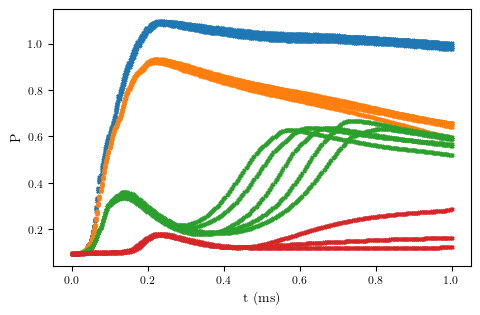

In [88]:
L_exp=len(P_exp[:,1])
colors = plt.cm.tab10.colors

for k, j in enumerate(n):
    # Seleccionar el color correspondiente de la paleta
    color = colors[k % len(colors)]  # Asegurarse de que no se salga del rango de colores disponibles
    for i in range(j):
        # Aquí puedes pasar el color seleccionado en cada iteración
        # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
        plt.scatter(X_star[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,0],P_star[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)], marker='x', s=5,  color=color)


plt.xlabel('t (ms)')
plt.ylabel('P')
plt.show()

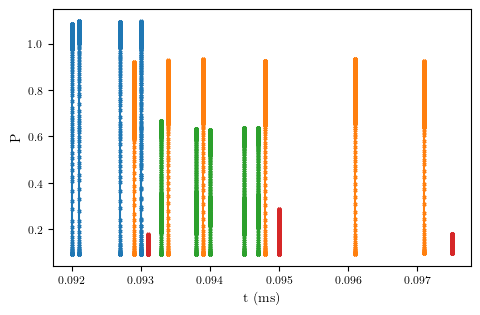

In [89]:
L_exp=len(P_exp[:,1])
for k, j in enumerate(n):
    # Seleccionar el color correspondiente de la paleta
    color = colors[k % len(colors)]  # Asegurarse de que no se salga del rango de colores disponibles
    for i in range(j):
        plt.plot(X_star[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,1],P_exp[:, (i + np.sum(n[:k]))], color=color)
        plt.scatter(X_star[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,1],P_star[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)], marker='x', color=color, s=5)

plt.xlabel('t (ms)')
plt.ylabel('P ')
plt.show()

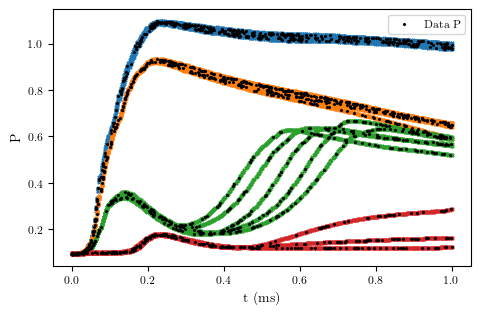

In [90]:
L_exp=len(P_exp[:,1])
colors = plt.cm.tab10.colors

for k, j in enumerate(n):
    # Seleccionar el color correspondiente de la paleta
    color = colors[k % len(colors)]  # Asegurarse de que no se salga del rango de colores disponibles
    for i in range(j):
        # Aquí puedes pasar el color seleccionado en cada iteración
        # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
        plt.scatter(X_star[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,0],P_star[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)], marker='x', s=5,  color=color)


plt.xlabel('t (ms)')
plt.ylabel('P')

plt.scatter(X_u_train[:,0], P_train, marker='x', s=2, color='black',label='Data P')

plt.legend()

# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

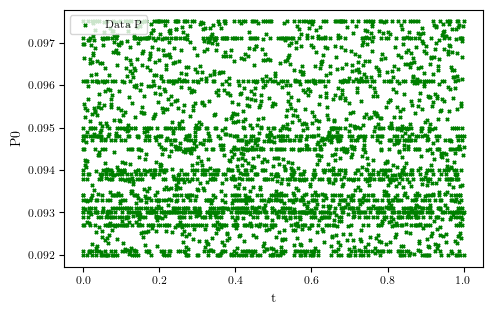

In [91]:

plt.scatter(X_f_train_tf[:,0], X_f_train_tf[:,1], s=5, marker='x', color='green',label='Data P')


plt.legend()
plt.xlabel('t')
plt.ylabel('P0')
# plt.savefig('figures/P_phi.pdf')
plt.show()

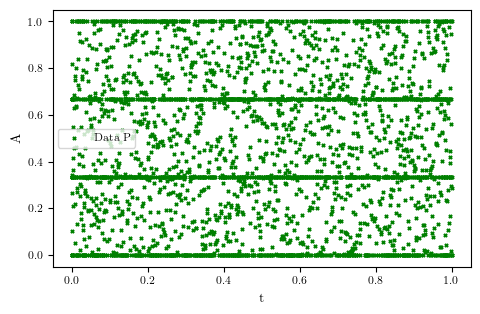

In [92]:

plt.scatter(X_f_train_tf[:,0], X_f_train_tf[:,2], s=5, marker='x', color='green',label='Data P')


plt.legend()
plt.xlabel('t')
plt.ylabel('A')
# plt.savefig('figures/P_phi.pdf')
plt.show()

In [93]:
np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
#os.environ[‘TF_ENABLE_AUTO_MIXED_PRECISION’] = ‘1’



# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    # A = 2.0*(X - lb)/(ub - lb) - 1.0
    A=X
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b 


def net(t, w, b):
    p = DNN(t, w, b)
    return p

def loss_weight(N_r, N_b):
    alpha_b = tf.Variable(tf.reshape(tf.repeat(1000.0, N_b), (N_b, -1))) 
    alpha_r = tf.Variable(tf.ones(shape=[N_r+N_b, 3]), dtype=tf.float32)
    # alpha_0 = tf.Variable(tf.reshape(tf.repeat(1000.0, N_exp*2), (N_exp*2, -1))) 
    alpha_0 = tf.Variable(tf.reshape(tf.repeat(1000.0, N_exp * 2 * 2), (N_exp * 2, 2)))
    return alpha_r, alpha_b, alpha_0


#@tf.function(jit_compile=True)
@tf.function()
def net_f(X_f, W_p, b_p, W_phi, b_phi, W_a, b_a, lnv):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([X_f])
        u=net(X_f, W_p, b_p)

        lnp=u[:,0:1]
        lns=u[:,1:2]
        lna=u[:,2:3]


        p=tf.exp(lnp)
        s=tf.exp(lns)
        a=tf.exp(lna)

        d=tf.exp(lnv[0:1])
        # l=tf.exp(lnv[1:2])

        # phi=tf.exp(net(tf.concat([p, s, l],1), W_phi, b_phi))
        phi_s=net(s, W_phi, b_phi)
        phi_s1=tf.exp(phi_s[...,0:1])
        phi_s2=tf.exp(phi_s[...,1:2])
        phi_a=net(a, W_a, b_a)
        phi_a1=tf.exp(phi_a[...,0:1])
        phi_a2=tf.exp(phi_a[...,1:2])   




    p_t = tape1.gradient(p, X_f)[...,0:1]
    s_t = tape1.gradient(s, X_f)[...,0:1]
    a_t = tape1.gradient(a, X_f)[...,0:1]


    f_p = p_t - phi_s1*p*s + phi_a1*p*a + d*p
    f_s = s_t + p*s*phi_s2
    f_a = a_t + p*a*phi_a2

    
    return f_p, f_s, f_a




#@tf.function()
# @tf.function()
def train_step(W_p, b_p,  W_phi, b_phi,  W_a, b_a,  X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_s_tf, uu01_a_tf, lambda_r, lambda_b, lambda_0, lnv, opt):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W_p, b_p, W_phi, b_phi, W_a, b_a, lambda_b, lambda_r, lambda_0, lnv])
        u_nn = net(X_u_train_tf, W_p, b_p) 
        lnp=u_nn[:,0:1]
        p_nn=tf.exp(lnp)
        f_p, f_s, f_a = net_f(X_f_train_tf, W_p, b_p, W_phi, b_phi, W_a, b_a, lnv)

        u_00 = net(xx01_tf, W_p, b_p) 
        s_00=tf.exp(u_00[:,1:2])
        u_00 = net(xx01_tf, W_p, b_p) 
        a_00=tf.exp(u_00[:,2:3])

        loss_p = tf.square(lambda_b*(p_nn - P_train_tf))
        loss_0s = tf.square(lambda_0[:,0:1]*(s_00 - uu01_s_tf))
        # loss_0a = tf.square(lambda_0[:N_exp:,1:2]*(a_00 - xx01_tf[:N_exp,2:3]))
        loss_0a = tf.square(lambda_0[:,1:2]*(a_00 - uu01_a_tf))
        loss_fp = tf.square(lambda_r[:,0:1]*f_p) 
        loss_fs = tf.square(lambda_r[:,1:2]*f_s)
        loss_fa = tf.square(lambda_r[:,2:3]*f_a) 

        loss =  tf.reduce_mean(loss_p) + tf.reduce_mean(loss_fp)+ tf.reduce_mean(loss_fs)+ tf.reduce_mean(loss_fa)+ tf.reduce_mean(loss_0s)+ tf.reduce_mean(loss_0a)

    grads_p = tape.gradient(loss, train_vars(W_p, b_p))
    grads_phi = tape.gradient(loss, train_vars(W_phi, b_phi))
    grads_a = tape.gradient(loss, train_vars(W_a, b_a))

    grads_lnv = tape.gradient(loss, lnv)
    grads_u = tape.gradient(loss, lambda_r)
    grads_b = tape.gradient(loss, lambda_b)
    grads_0 = tape.gradient(loss, lambda_0)


    opt.apply_gradients(zip(grads_p, train_vars(W_p, b_p)))
    opt.apply_gradients(zip(grads_phi, train_vars(W_phi, b_phi)))
    opt.apply_gradients(zip(grads_a, train_vars(W_a, b_a)))

    opt.apply_gradients(zip([grads_lnv], [lnv]))
    opt.apply_gradients(zip([-grads_u], [lambda_r]))
    opt.apply_gradients(zip([-grads_b], [lambda_b]))
    opt.apply_gradients(zip([-grads_0], [lambda_0]))

   
    # return loss, tf.reduce_mean(tf.square((p_nn - P_train_tf))), tf.reduce_mean(tf.square(f_p)), tf.reduce_mean(tf.square(f_s)), tf.reduce_mean(tf.square(f_a)), tf.reduce_mean(tf.square((a_00 - xx01_tf[:N_exp,2:3])))
    return loss, tf.reduce_mean(tf.square((p_nn - P_train_tf))), tf.reduce_mean(tf.square(f_p)), tf.reduce_mean(tf.square(f_s)), tf.reduce_mean(tf.square(f_a)), tf.reduce_mean(tf.square((a_00 - uu01_a_tf)))



layers = [3, 20, 20, 3]

L = len(layers)
W_p = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_p = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

layers = [1, 20, 20, 20, 2]

W_a = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_a = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

layers = [1, 20, 20, 20, 2]
L = len(layers)

W_phi = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_phi = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

lnv = tf.Variable(tf.reshape(tf.repeat(1.0, 1), (1, -1)), dtype=tf.float32) 
lambda_r, lambda_b, lambda_0 = loss_weight(N_f, N_d)



In [94]:
lr = 3e-3


optimizer = tf.optimizers.Adam(learning_rate=lr)
optimizer2 = tf.optimizers.Adam(learning_rate=lr/30)
# optimizer3 = tf.optimizers.Adam(learning_rate=lr/100)
# optimizer3 = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
optimizer3 = tf.optimizers.Adam(learning_rate=lr/40)

# optimizer3 = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9, clipnorm=10.0)


start_time = time.time()
it=0
loss = []
loss_d = []
loss_fisp = []
loss_fiss = []
loss_fisa = []
loss_0=[]
# loss_fisa = []

# Make a new Function and ConcreteFunction for each optimizer.
train_step_1 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi, b_phi, W_a, b_a, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_s_tf, uu01_a_tf,  lambda_r, lambda_b, lambda_0, lnv, optimizer)
train_step_2 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi, b_phi, W_a, b_a, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_s_tf, uu01_a_tf, lambda_r, lambda_b, lambda_0, lnv, optimizer2)
# train_step_3 = tf.function(train_dynamic_step).get_concrete_function(W_phi, b_phi,  W_a, b_a, X_f_train_tf, lambda_r, lnv, optimizer2)


In [159]:
# Nmax=10**5
Nmax=25*10**3
Nmax=10**5
# Nmax=6*10**3


while it <= Nmax:
    # if it<5*10**4:
    loss_, loss_p, loss_fp, loss_fs, loss_fa, loss_f0a = train_step_1(W_p, b_p, W_phi, b_phi, W_a, b_a, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_s_tf, uu01_a_tf, lambda_r, lambda_b, lambda_0, lnv)
    # else:
    #     loss_, loss_p, loss_fp, loss_fs, loss_fa, loss_f0a = train_step_2(W_p, b_p, W_phi, b_phi, W_a, b_a, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_s_tf, uu01_a_tf, lambda_r, lambda_b, lambda_0, lnv)
    # else:
    #     loss_, loss_p, loss_fp, loss_fs, loss_fa = train_step_3(W_phi, b_phi,  W_a, b_a, X_f_train_tf, lambda_r, lnv)

    loss.append(loss_)
    loss_d.append(loss_p)
    loss_fisp.append(loss_fp)
    loss_fiss.append(loss_fs)
    loss_fisa.append(loss_fa)
    loss_0.append(loss_f0a)




    if it % 10 == 0:

        print(f"Iteration is: {it}")
        # print(f"Total loss is: {loss_}")
        print(f"Data loss is: {loss_p}")
        print(f"Physicial loss of p is: {loss_fp}")
        print(f"Physicial loss of s is: {loss_fs}")
        # if n%10000 ==0:
        #     loss_reg_=eval(W_p, b_p, W_phi_s, b_phi_s)
        #     loss_reg.append(loss_reg_)
        # print(f"Physicial loss of a is: {loss_fa}")

    it+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

Iteration is: 84940
Data loss is: 0.0012604143703356385
Physicial loss of p is: 0.0035512978211045265
Physicial loss of s is: 0.001043985248543322
Iteration is: 84950
Data loss is: 0.0012600835179910064
Physicial loss of p is: 0.00264099333435297
Physicial loss of s is: 0.000780675676651299
Iteration is: 84960
Data loss is: 0.0012555111898109317
Physicial loss of p is: 0.0074012139812111855
Physicial loss of s is: 0.001983347814530134
Iteration is: 84970
Data loss is: 0.0012669919524341822
Physicial loss of p is: 0.002972289454191923
Physicial loss of s is: 0.003084352472797036
Iteration is: 84980
Data loss is: 0.0012573894346132874
Physicial loss of p is: 0.0032757592853158712
Physicial loss of s is: 0.000589602452237159
Iteration is: 84990
Data loss is: 0.0012572887353599072
Physicial loss of p is: 0.002994164824485779
Physicial loss of s is: 0.0006619315827265382
Iteration is: 85000
Data loss is: 0.0012619568733498454
Physicial loss of p is: 0.00392183568328619
Physicial loss of s i

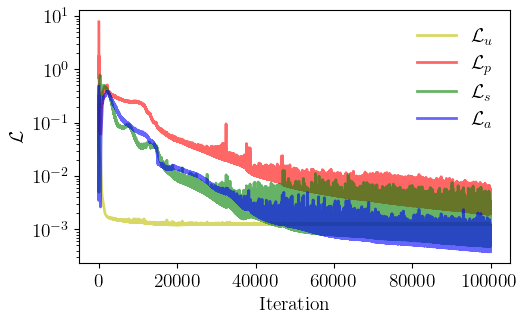

In [170]:
Nmax=len(loss)
ep = np.arange(0,Nmax, 1)
loss_list = [loss[i].numpy() for i in range(0,Nmax)]
loss_data_list = [loss_d[i].numpy() for i in range(0,Nmax)]
loss_phip_list = [loss_fisp[i].numpy() for i in range(0,Nmax)]
loss_phis_list = [loss_fiss[i].numpy() for i in range(0,Nmax)]
loss_phia_list = [loss_fisa[i].numpy() for i in range(0,Nmax)]
loss_0_list = [loss_0[i].numpy() for i in range(0,Nmax)]





plt.semilogy(ep, np.asarray(loss_data_list), 'y-', linewidth = 2, alpha=0.6, label = '$\mathcal{L}_u$')  
plt.semilogy(ep, np.asarray(loss_phip_list), 'r-', linewidth = 2, alpha=0.6, label ='$\mathcal{L}_p$')    
plt.semilogy(ep, np.asarray(loss_phis_list), 'g-', linewidth = 2, alpha=0.6, label = '$\mathcal{L}_s$') 
plt.semilogy(ep, np.asarray(loss_phia_list), 'b-', linewidth = 2, alpha=0.6, label = '$\mathcal{L}_a$')    
# plt.semilogy(ep, np.asarray(loss_0_list), color='orange', linestyle='-', linewidth = 2, alpha=0.6, label = '$a_0$')       




plt.legend(fontsize=14, ncols=1, frameon=False)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('$\mathcal{L}$', fontsize=14)    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Img/800/Loss_split.png')
plt.savefig('../Img/800/Loss_split.pdf')
plt.savefig('../Img/800/Loss_split.svg')
plt.show()

In [171]:
def predict(X_star_tf, w, b):
    u_pred = net(X_star_tf, w, b)
    return u_pred

## Evaluating total function
X_star_tf = tf.convert_to_tensor(X_star, dtype=tf.float32)  
# A_star_tf = tf.convert_to_tensor(A, dtype=tf.float32)    

u_pred = predict(X_star_tf, W_p, b_p)

# ## Evaluating unknown function
lnp=u_pred[:,0:1]
lns=u_pred[:,1:2]
lna=u_pred[:,2:3]


p=tf.exp(lnp)
s=tf.exp(lns)
a=tf.exp(lna)


# phi = tf.exp(predict(tf.concat([p, s, l],1), W_phi, b_phi))
phi_s = predict(s, W_phi, b_phi)
phi_s1 = tf.exp(phi_s[...,0:1])
phi_s2 = tf.exp(phi_s[...,1:2])
phi_a = predict(a, W_a, b_a)
phi_a1 = tf.exp(phi_a[...,0:1])
phi_a2 = tf.exp(phi_a[...,1:2]) 



d=tf.exp(lnv[0:1])

s_t=-np.array(p*s*phi_s2)
a_t=-np.array(p*a*phi_a2)



In [172]:
d

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.70844734]], dtype=float32)>

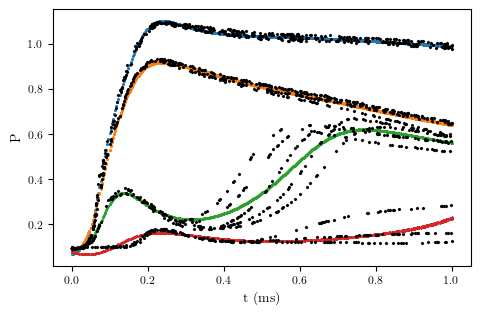

In [173]:


L_exp=len(P_exp[:,1])
colors = plt.cm.tab10.colors

for k, j in enumerate(n):
    # Seleccionar el color correspondiente de la paleta
    color = colors[k % len(colors)]  # Asegurarse de que no se salga del rango de colores disponibles
    for i in range(j):
        # Aquí puedes pasar el color seleccionado en cada iteración
        # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
        plt.scatter(X_star_tf[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,0],p[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)], marker='x', s=1,  color=color, label='Prediction P')
plt.scatter(X_u_train[:,0], P_train, marker='x', s=2, color='black',label='Data P')



plt.xlabel('t (ms)')
plt.ylabel('P')


# plt.legend()

# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

C:\Users\julia\AppData\Local\Temp\ipykernel_29856\1574483130.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('Oranges', len(n))
C:\Users\julia\AppData\Local\Temp\ipykernel_29856\1574483130.py:36: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, aspect=30, pad=0.02)  # Ajusta el tamaño y posición


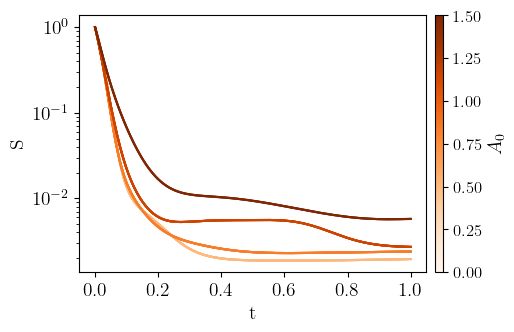

In [175]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Ejemplo de datos (asegúrate de usar tus datos reales)
# A = np.array([...])  # Define tus valores para A
# n = [...]           # Define los valores en n
# P_exp = np.random.rand(100, 2)  # Simulación de ejemplo
# X_star_tf = np.random.rand(200, 1)  # Simulación de ejemplo
# s = np.random.rand(200)  # Simulación de ejemplo

# Configuración de la colormap
norm = plt.Normalize(vmin=min(A), vmax=max(A)+0.5)  # Normaliza los valores de A
cmap = cm.Oranges  # Puedes cambiar a otro colormap si lo prefieres
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Necesario para la asociación con la colorbar

# Obtener la paleta de colores 'Oranges' de matplotlib
colors = cm.get_cmap('Oranges', len(n))

L_exp = len(P_exp[:, 1])

for k, j in enumerate(n):
    # Seleccionar el color correspondiente de la paleta
    color = cmap(norm(A[k]+0.5))  # Asocia un color de la paleta según el valor de A[k]
    for i in range(j):
        # Graficar utilizando el color seleccionado
        plt.plot(
            X_star_tf[L_exp * (i + np.sum(n[:k])) : L_exp * ((i + np.sum(n[:k])) + 1)][:, 0],
            s[L_exp * (i + np.sum(n[:k])) : L_exp * ((i + np.sum(n[:k])) + 1)],
            color=color,
            label='Prediction P'
        )

# Añade la colorbar
cbar = plt.colorbar(sm, aspect=30, pad=0.02)  # Ajusta el tamaño y posición
cbar.set_label(r'$A_0$', fontsize=14)  # Etiqueta de la colorbar
cbar.ax.tick_params(labelsize=12)

plt.xlabel('t', fontsize=14)
plt.ylabel('S', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.savefig('../Img/800/Result_s.png')
plt.savefig('../Img/800/Result_s.pdf')
plt.savefig('../Img/800/Result_s.svg')
# plt.xscale('log')
# plt.tight_layout()

plt.show()


C:\Users\julia\AppData\Local\Temp\ipykernel_29856\1033350283.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('Oranges', len(n))
C:\Users\julia\AppData\Local\Temp\ipykernel_29856\1033350283.py:36: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, aspect=30, pad=0.02)  # Ajusta el tamaño y posición


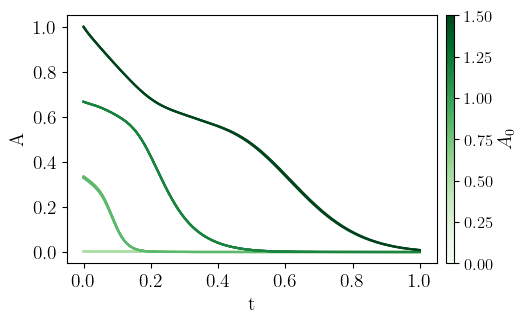

In [176]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Ejemplo de datos (asegúrate de usar tus datos reales)
# A = np.array([...])  # Define tus valores para A
# n = [...]           # Define los valores en n
# P_exp = np.random.rand(100, 2)  # Simulación de ejemplo
# X_star_tf = np.random.rand(200, 1)  # Simulación de ejemplo
# s = np.random.rand(200)  # Simulación de ejemplo

# Configuración de la colormap
norm = plt.Normalize(vmin=min(A), vmax=max(A)+0.5)  # Normaliza los valores de A
cmap = cm.Greens  # Puedes cambiar a otro colormap si lo prefieres
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Necesario para la asociación con la colorbar

# Obtener la paleta de colores 'Oranges' de matplotlib
colors = cm.get_cmap('Oranges', len(n))

L_exp = len(P_exp[:, 1])

for k, j in enumerate(n):
    # Seleccionar el color correspondiente de la paleta
    color = cmap(norm(A[k]+0.5))  # Asocia un color de la paleta según el valor de A[k]
    for i in range(j):
        # Graficar utilizando el color seleccionado
        plt.plot(
            X_star_tf[L_exp * (i + np.sum(n[:k])) : L_exp * ((i + np.sum(n[:k])) + 1)][:, 0],
            a[L_exp * (i + np.sum(n[:k])) : L_exp * ((i + np.sum(n[:k])) + 1)],
            color=color,
            label='Prediction P'
        )

# Añade la colorbar
cbar = plt.colorbar(sm, aspect=30, pad=0.02)  # Ajusta el tamaño y posición
cbar.set_label(r'$A_0$', fontsize=14)  # Etiqueta de la colorbar
cbar.ax.tick_params(labelsize=12)

plt.xlabel('t', fontsize=14)
plt.ylabel('A', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('../Img/800/Result_a.png')
plt.savefig('../Img/800/Result_a.pdf')
plt.savefig('../Img/800/Result_a.svg')

plt.tight_layout()  # Ajusta automáticamente los márgenes
plt.show()


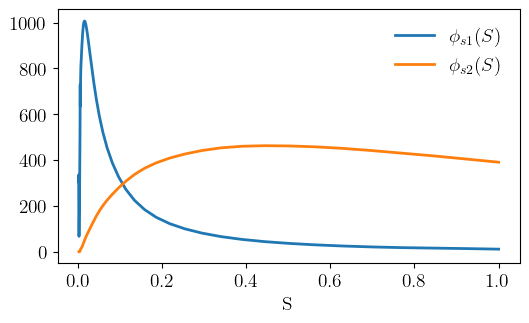

In [177]:

# plt.plot(p[L_exp*i:L_exp*(i+1)][:,0], phi[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[0])
plt.plot(s[L_exp*i:L_exp*(i+1)][:,0], phi_s1[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  label=r'$\phi_{s1}(S)$')
plt.plot(s[L_exp*i:L_exp*(i+1)][:,0], phi_s2[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  label=r'$\phi_{s2}(S)$')


plt.xlabel('S', fontsize=14)
plt.legend(fontsize=14, ncols=1, frameon=False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('../Img/800/Result_phi_s.png')
plt.savefig('../Img/800/Result_phi_s.pdf')
plt.savefig('../Img/800/Result_phi_s.svg')
plt.tight_layout()

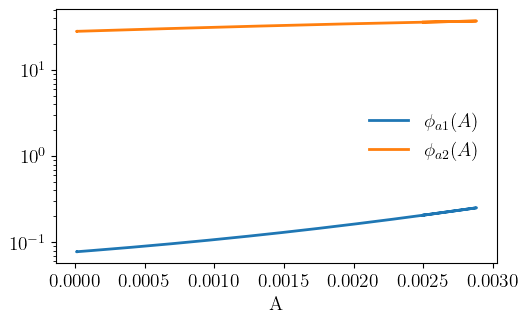

In [182]:

plt.plot(a[L_exp*i:L_exp*(i+1)][:,0], phi_a1[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  label=r'$\phi_{a1}(A)$')
plt.plot(a[L_exp*i:L_exp*(i+1)][:,0], phi_a2[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  label=r'$\phi_{a2}(A)$')


plt.xlabel('A', fontsize=14)
plt.legend(fontsize=14, ncols=1, frameon=False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.savefig('../Img/800/Result_phi_a.png')
plt.savefig('../Img/800/Result_phi_a.pdf')
plt.savefig('../Img/800/Result_phi_a.svg')
plt.tight_layout()

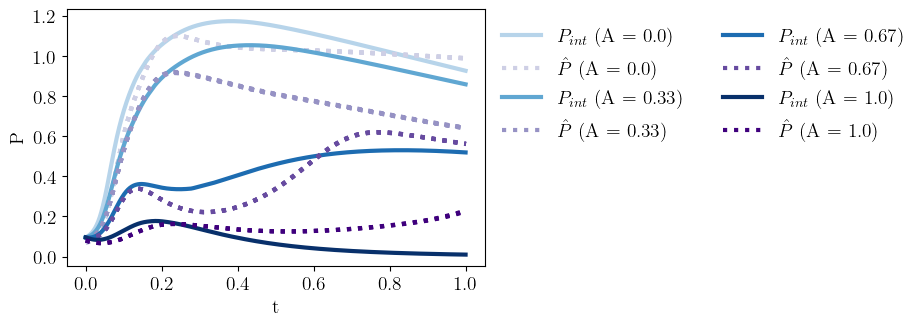

In [183]:
Nt=1000

# A_0=np.array([0,0.75, 1.25,2, 2.5,3,3.75])
# A_0=np.array([0,1.25, 2.5,3.75])

colors_p = plt.cm.Blues(np.linspace(0.3, 1, len(A)))
colors_s = plt.cm.Oranges(np.linspace(0.3, 1, len(A)))
colors_t = plt.cm.Purples(np.linspace(0.3, 1, len(A)))

for idx, a_ in enumerate(A):

    T_int=np.zeros(Nt)
    P_int=np.zeros(Nt)
    S_int=np.zeros(Nt)
    A_int=np.zeros(Nt)



    dt=0.001

    T_int[0]=0
    P_int[0]=np.mean(P0) #Initial conditions
    A_int[0]=np.array(a_) #Initial conditions
    S_int[0]=np.array(s[0]) #Initial conditions

    # l=tf.exp(predict(tf.convert_to_tensor(a.reshape([-1,1]), dtype=tf.float32), W_a, b_a))
    for i in range(1,Nt):

        # PSL=tf.concat([tf.convert_to_tensor(P_int[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32), l],1)

        # REVISAAAAAR
        PHI_S=predict(tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32) , W_phi, b_phi)
        PHI_S1=tf.exp(PHI_S[...,0:1])
        PHI_S2=tf.exp(PHI_S[...,1:2])
        PHI_A=predict(tf.convert_to_tensor(A_int[i-1].reshape([-1,1]), dtype=tf.float32) , W_a, b_a)
        PHI_A1=tf.exp(PHI_A[...,0:1])
        PHI_A2=tf.exp(PHI_A[...,1:2])

        P_int[i]=P_int[i-1]+(P_int[i-1]*S_int[i-1]*PHI_S1 - P_int[i-1]*A_int[i-1]*PHI_A1 - d*P_int[i-1])*dt
        S_int[i]=S_int[i-1]-P_int[i-1]*S_int[i-1]*PHI_S2*dt
        A_int[i]=A_int[i-1]-P_int[i-1]*A_int[i-1]*PHI_A2*dt
        T_int[i]=T_int[i-1]+dt

    plt.plot(T_int, P_int, linewidth=3,linestyle='-', label='$P_{int}$'+f' (A = {np.round(a_, 2)})', color=colors_p[idx])
    # plt.plot(T_int, S_int,linewidth=3, linestyle='--', label='$S_{int}$'+f' (A = {np.round(a_, 2)})', color=colors_s[idx])
    # plt.plot(T_int, A_int,  linestyle=':', label=f'Numeric integration dAdT {a}')
    i=0
    plt.plot(X_star_tf[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)][:,0],p[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)],linewidth=3, linestyle=':',color=colors_t[idx], label='$\hat{P}$'+f' (A = {np.round(A[idx], 2)})')

    for i in range(1,n[idx]):
        # Aquí puedes pasar el color seleccionado en cada iteración
        # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
        plt.plot(X_star_tf[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)][:,0],p[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)],linewidth=3, linestyle=':',color=colors_t[idx])


plt.legend(fontsize=14, ncols=2, frameon=False, bbox_to_anchor=(1, 1))

plt.xlabel('t', fontsize=14)
plt.ylabel('P', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
# plt.ylim(0,1.5)
# plt.tight_layout()
plt.savefig('../Img/800/Result_int.png')
plt.savefig('../Img/800/Result_int.pdf')
plt.savefig('../Img/800/Result_int.svg')
plt.show()

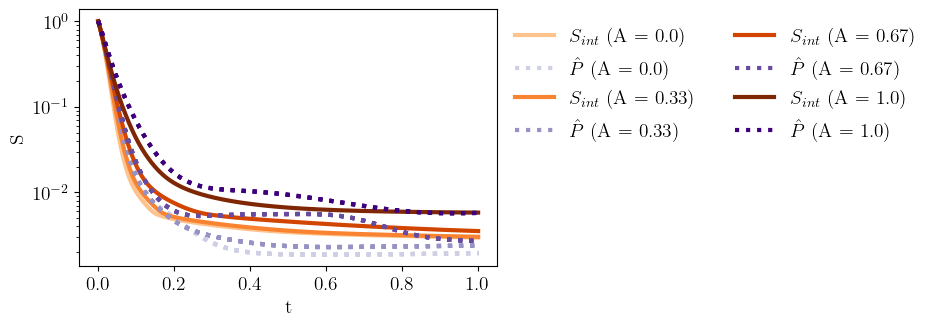

In [191]:
Nt=1000

# A_0=np.array([0,0.75, 1.25,2, 2.5,3,3.75])
# A_0=np.array([0,1.25, 2.5,3.75])

colors_p = plt.cm.Blues(np.linspace(0.3, 1, len(A)))
colors_s = plt.cm.Oranges(np.linspace(0.3, 1, len(A)))
colors_t = plt.cm.Purples(np.linspace(0.3, 1, len(A)))

for idx, a_ in enumerate(A):

    T_int=np.zeros(Nt)
    P_int=np.zeros(Nt)
    S_int=np.zeros(Nt)
    A_int=np.zeros(Nt)



    dt=0.001

    T_int[0]=0
    P_int[0]=np.mean(P0) #Initial conditions
    A_int[0]=np.array(a_) #Initial conditions
    S_int[0]=np.array(s[0]) #Initial conditions

    # l=tf.exp(predict(tf.convert_to_tensor(a.reshape([-1,1]), dtype=tf.float32), W_a, b_a))
    for i in range(1,Nt):

        # PSL=tf.concat([tf.convert_to_tensor(P_int[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32), l],1)

        # REVISAAAAAR
        PHI_S=predict(tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32) , W_phi, b_phi)
        PHI_S1=tf.exp(PHI_S[...,0:1])
        PHI_S2=tf.exp(PHI_S[...,1:2])
        PHI_A=predict(tf.convert_to_tensor(A_int[i-1].reshape([-1,1]), dtype=tf.float32) , W_a, b_a)
        PHI_A1=tf.exp(PHI_A[...,0:1])
        PHI_A2=tf.exp(PHI_A[...,1:2])

        P_int[i]=P_int[i-1]+(P_int[i-1]*S_int[i-1]*PHI_S1 - P_int[i-1]*A_int[i-1]*PHI_A1 - d*P_int[i-1])*dt
        S_int[i]=S_int[i-1]-P_int[i-1]*S_int[i-1]*PHI_S2*dt
        A_int[i]=A_int[i-1]-P_int[i-1]*A_int[i-1]*PHI_A2*dt
        T_int[i]=T_int[i-1]+dt

    # plt.plot(T_int, A_int, linewidth=3,linestyle='-', label='$A_{int}$'+f' (A = {np.round(a_, 2)})', color=colors_p[idx])
    plt.plot(T_int, S_int,linewidth=3, linestyle='-', label='$S_{int}$'+f' (A = {np.round(a_, 2)})', color=colors_s[idx])
    # plt.plot(T_int, A_int,  linestyle=':', label=f'Numeric integration dAdT {a}')
    i=0
    plt.plot(X_star_tf[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)][:,0],s[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)],linewidth=3, linestyle=':',color=colors_t[idx], label='$\hat{P}$'+f' (A = {np.round(A[idx], 2)})')

    for i in range(1,n[idx]):
        # Aquí puedes pasar el color seleccionado en cada iteración
        # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
        plt.plot(X_star_tf[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)][:,0],s[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)],linewidth=3, linestyle=':',color=colors_t[idx])


plt.legend(fontsize=14, ncols=2, frameon=False, bbox_to_anchor=(1, 1))

plt.xlabel('t', fontsize=14)
plt.ylabel('S', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.yscale('log')
# plt.tight_layout()
plt.savefig('../Img/800/Result_int_s.png')
plt.savefig('../Img/800/Result_int_s.pdf')
plt.savefig('../Img/800/Result_int_s.svg')
plt.show()

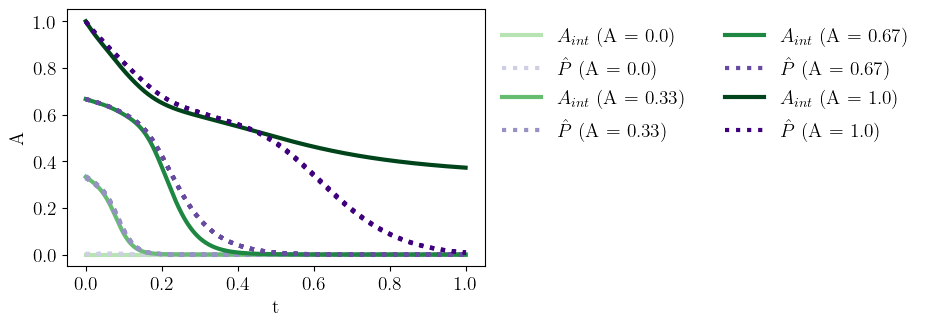

In [194]:
Nt=1000

# A_0=np.array([0,0.75, 1.25,2, 2.5,3,3.75])
# A_0=np.array([0,1.25, 2.5,3.75])

colors_p = plt.cm.Greens(np.linspace(0.3, 1, len(A)))
colors_s = plt.cm.Oranges(np.linspace(0.3, 1, len(A)))
colors_t = plt.cm.Purples(np.linspace(0.3, 1, len(A)))

for idx, a_ in enumerate(A):

    T_int=np.zeros(Nt)
    P_int=np.zeros(Nt)
    S_int=np.zeros(Nt)
    A_int=np.zeros(Nt)



    dt=0.001

    T_int[0]=0
    P_int[0]=np.mean(P0) #Initial conditions
    A_int[0]=np.array(a_) #Initial conditions
    S_int[0]=np.array(s[0]) #Initial conditions

    # l=tf.exp(predict(tf.convert_to_tensor(a.reshape([-1,1]), dtype=tf.float32), W_a, b_a))
    for i in range(1,Nt):

        # PSL=tf.concat([tf.convert_to_tensor(P_int[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32), l],1)

        # REVISAAAAAR
        PHI_S=predict(tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32) , W_phi, b_phi)
        PHI_S1=tf.exp(PHI_S[...,0:1])
        PHI_S2=tf.exp(PHI_S[...,1:2])
        PHI_A=predict(tf.convert_to_tensor(A_int[i-1].reshape([-1,1]), dtype=tf.float32) , W_a, b_a)
        PHI_A1=tf.exp(PHI_A[...,0:1])
        PHI_A2=tf.exp(PHI_A[...,1:2])

        P_int[i]=P_int[i-1]+(P_int[i-1]*S_int[i-1]*PHI_S1 - P_int[i-1]*A_int[i-1]*PHI_A1 - d*P_int[i-1])*dt
        S_int[i]=S_int[i-1]-P_int[i-1]*S_int[i-1]*PHI_S2*dt
        A_int[i]=A_int[i-1]-P_int[i-1]*A_int[i-1]*PHI_A2*dt
        T_int[i]=T_int[i-1]+dt

    plt.plot(T_int, A_int, linewidth=3,linestyle='-', label='$A_{int}$'+f' (A = {np.round(a_, 2)})', color=colors_p[idx])
    # plt.plot(T_int, S_int,linewidth=3, linestyle='-', label='$S_{int}$'+f' (A = {np.round(a_, 2)})', color=colors_s[idx])
    # plt.plot(T_int, A_int,  linestyle=':', label=f'Numeric integration dAdT {a}')
    i=0
    plt.plot(X_star_tf[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)][:,0],a[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)],linewidth=3, linestyle=':',color=colors_t[idx], label='$\hat{P}$'+f' (A = {np.round(A[idx], 2)})')

    for i in range(1,n[idx]):
        # Aquí puedes pasar el color seleccionado en cada iteración
        # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
        plt.plot(X_star_tf[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)][:,0],a[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)],linewidth=3, linestyle=':',color=colors_t[idx])


plt.legend(fontsize=14, ncols=2, frameon=False, bbox_to_anchor=(1, 1))

plt.xlabel('t', fontsize=14)
plt.ylabel('A', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
# plt.yscale('log')
# plt.tight_layout()
plt.savefig('../Img/800/Result_int_a.png')
plt.savefig('../Img/800/Result_int_a.pdf')
plt.savefig('../Img/800/Result_int_a.svg')
plt.show()

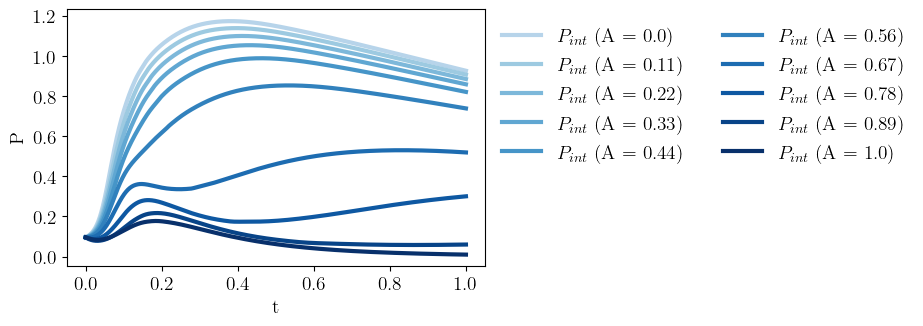

In [186]:
Nt=1000

# A_0=np.array([0,0.75, 1.25,2, 2.5,3,3.75])
# A_0=np.array([0,1.25, 2.5,3.75])
A_int=np.linspace(0,1,10)

colors_p = plt.cm.Blues(np.linspace(0.3, 1, len(A_int)))
# colors_s = plt.cm.Oranges(np.linspace(0.3, 1, len(A_int)))
# colors_t = plt.cm.Purples(np.linspace(0.3, 1, len(A)))
for idx, a_ in enumerate(A_int):

    T_int=np.zeros(Nt)
    P_int=np.zeros(Nt)
    S_int=np.zeros(Nt)
    A_int=np.zeros(Nt)



    dt=0.001

    T_int[0]=0
    P_int[0]=np.mean(P0) #Initial conditions
    A_int[0]=np.array(a_) #Initial conditions
    S_int[0]=np.array(s[0]) #Initial conditions

    # l=tf.exp(predict(tf.convert_to_tensor(a.reshape([-1,1]), dtype=tf.float32), W_a, b_a))
    for i in range(1,Nt):

        # PSL=tf.concat([tf.convert_to_tensor(P_int[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32), l],1)

        # REVISAAAAAR
        PHI_S=predict(tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32) , W_phi, b_phi)
        PHI_S1=tf.exp(PHI_S[...,0:1])
        PHI_S2=tf.exp(PHI_S[...,1:2])
        PHI_A=predict(tf.convert_to_tensor(A_int[i-1].reshape([-1,1]), dtype=tf.float32) , W_a, b_a)
        PHI_A1=tf.exp(PHI_A[...,0:1])
        PHI_A2=tf.exp(PHI_A[...,1:2])

        P_int[i]=P_int[i-1]+(P_int[i-1]*S_int[i-1]*PHI_S1 - P_int[i-1]*A_int[i-1]*PHI_A1 - d*P_int[i-1])*dt
        S_int[i]=S_int[i-1]-P_int[i-1]*S_int[i-1]*PHI_S2*dt
        A_int[i]=A_int[i-1]-P_int[i-1]*A_int[i-1]*PHI_A2*dt
        T_int[i]=T_int[i-1]+dt

    plt.plot(T_int, P_int, linewidth=3,linestyle='-', label='$P_{int}$'+f' (A = {np.round(a_, 2)})', color=colors_p[idx])
    # plt.plot(T_int, S_int,linewidth=3, linestyle='--', label='$S_{int}$'+f' (A = {np.round(a_, 2)})', color=colors_s[idx])
    # plt.plot(T_int, A_int,  linestyle=':', label=f'Numeric integration dAdT {a}')
    # i=0
    # plt.plot(X_star_tf[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)][:,0],p[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)],linewidth=3, linestyle=':',color=colors_t[idx], label='$\hat{P}$'+f' (A = {np.round(A[idx], 2)})')

    # for i in range(1,n[idx]):
    #     # Aquí puedes pasar el color seleccionado en cada iteración
    #     # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
    #     plt.plot(X_star_tf[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)][:,0],p[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)],linewidth=3, linestyle=':',color=colors_t[idx])


plt.legend(fontsize=14, ncols=2, frameon=False, bbox_to_anchor=(1, 1))

plt.xlabel('t', fontsize=14)
plt.ylabel('P', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
# plt.ylim(0,1.5)
# plt.tight_layout()
plt.savefig('../Img/800/Result_int_2.png')
plt.savefig('../Img/800/Result_int_2.pdf')
plt.savefig('../Img/800/Result_int_2.svg')
plt.show()